In [2]:
import pandas as pd
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import catboost

from scikeras.wrappers import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
import seaborn as sns

import matplotlib.pyplot as plt
from time import time

import etna
from etna.datasets.tsdataset import TSDataset

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [25]:
train_df = pd.read_csv('Cars_train.csv')
valid_df = pd.read_csv('Cars_valid.csv')
del train_df['Unnamed: 0']
del valid_df['Unnamed: 0']
train_df.isnull().any()

C:\Users\Mihay\AppData\Local\Temp\ipykernel_13408\1783425920.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('Cars_train.csv')


Registration Date                 False
Quantity Industry Registration    False
Sales Type                         True
Manufacturer Description          False
dtype: bool

In [27]:
train_df['timestamp'] = train_df['Registration Date'].str.slice(0, 10)
valid_df['timestamp'] = valid_df['Registration Date'].str.slice(0, 10)
train_df['target'] = train_df['Quantity Industry Registration'].apply(lambda x: int(x))
valid_df['target'] = valid_df['Quantity Industry Registration'].apply(lambda x: int(x))
train_df['segment'] = train_df['Manufacturer Description']
valid_df['segment'] = valid_df['Manufacturer Description']
del train_df['Registration Date']
del valid_df['Registration Date']
del train_df['Quantity Industry Registration']
del valid_df['Quantity Industry Registration']
del train_df['Sales Type']
del valid_df['Sales Type']
del train_df['Manufacturer Description']
del valid_df['Manufacturer Description']

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210988 entries, 0 to 210987
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   timestamp  210988 non-null  object
 1   target     210988 non-null  int64 
 2   segment    210988 non-null  object
dtypes: int64(1), object(2)
memory usage: 4.8+ MB


In [60]:
d_last = train_df[train_df.duplicated(keep='last')].reset_index()
d_first = train_df[train_df.duplicated(keep='first')].reset_index()


d_first.apply(lambda x: d_last['timestamp'].str.find(x['timestamp']))

0       2
1       2
2       2
3       2
4       2
       ..
285     2
286    18
287     4
288     4
289    22
Name: target, Length: 290, dtype: int64

In [35]:
def combine(x):
    print(x)
    return x

In [50]:
grouped = train_df.groupby(['timestamp', 'segment'])
result = grouped.agg('sum')

In [51]:
result

target
timestamp  segment                                    
2005-01-03 AGRALE                                    3
           AUDI                                      7
           BMW                                       3
           CITROEN                                  35
           FERRARI                                   1
...                                                ...
2023-05-05 SUZUKI                                    4
           TAC MOTORS                                2
           TOYOTA                                  844
           VOLKSWAGEN                             1428
           VOLVO                                   142

[197780 rows x 1 columns]

In [5]:
train_df = train_df.drop_duplicates()

In [9]:
train_df.head()

,timestamp,target,segment
0,2005-01-03,14,VOLVO
1,2005-01-03,6,LAND ROVER
2,2005-01-03,85,HONDA
3,2005-01-03,35,CITROEN
4,2005-01-03,81,PEUGEOT


In [7]:
grouped = train_df.groupby('segment')
grouped['target'].describe()

,count,mean,std,min,25%,50%,75%,max
segment,,,,,,,,
ACURA,4.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
AGRALE,3496.0,4.269451,3.848348,1.0,2.00,3.0,6.00,64.0
ALFA ROMEO,108.0,1.037037,0.189733,1.0,1.00,1.0,1.00,2.0
AM General,2.0,1.500000,0.707107,1.0,1.25,1.5,1.75,2.0
AMC,3.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
...,...,...,...,...,...,...,...,...
WILLYS,22.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
ZIMMER,2.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
ZNA,3.0,2.000000,1.000000,1.0,1.50,2.0,2.50,3.0


In [41]:
df = TSDataset.to_dataset(result)
df.head()

KeyError: 'timestamp'

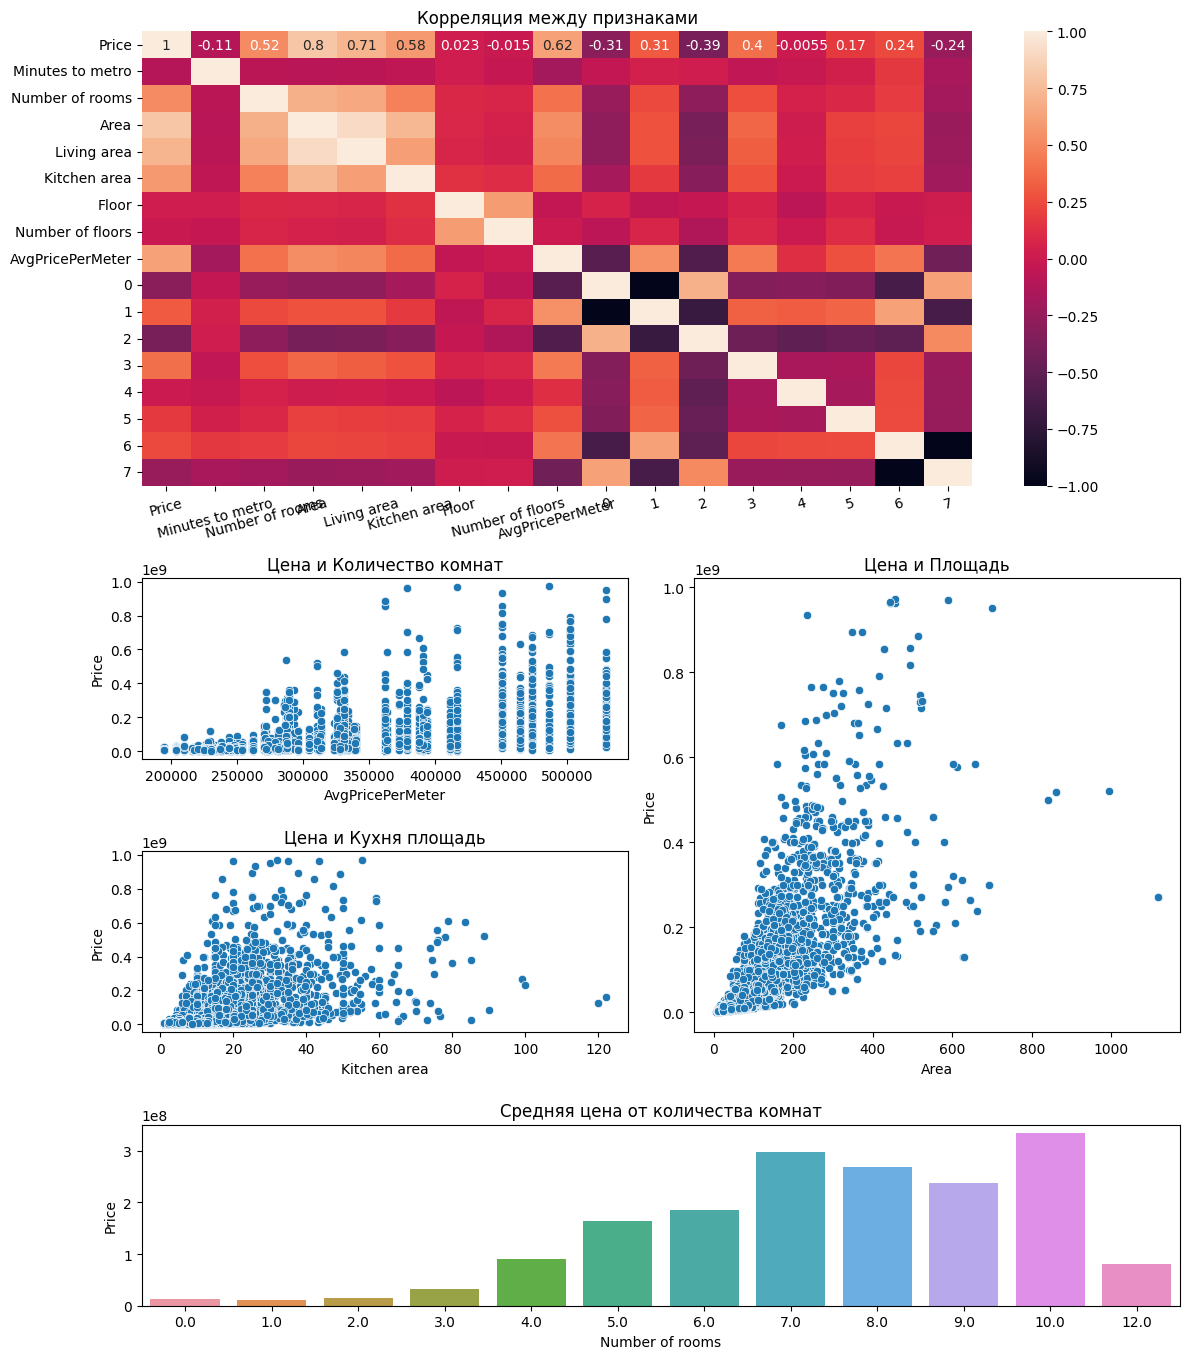

In [413]:
df = train_df
correlation = df.select_dtypes(include = ['float64', 'int64']).corr()

# Настроим размер общего холста (Figure)
fig = plt.figure(figsize=(12, 16))

# График 1 - Матрица корреляции для всех признаков 
ax1 = plt.subplot2grid((6, 2), (0, 0), rowspan = 2, colspan = 2)
sns.heatmap(correlation, annot = True, ax = ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15) # Поворот меток на оси x
ax1.set_title('Корреляция между признаками')


# График 2 - Взаимосвязь между ценой и количеством комнат
ax2 = plt.subplot2grid((6, 2), (2, 0))
sns.scatterplot(data = df,
                x = 'AvgPricePerMeter',
                y = 'Price',
                ax = ax2)
# ax2.set_xticks(range(0,,1))
ax2.set_title('Цена и Количество комнат')


# График 3 - Взаимосвязь между ценой и площадью
ax3 = plt.subplot2grid((6, 2), (2, 1), rowspan = 2)
sns.scatterplot(data = df,
                x = 'Area',
                y = 'Price',
                ax = ax3)
ax3.set_title('Цена и Площадь')


# График 4 - Взаимосвязь между ценой и площадью кухни
ax4 = plt.subplot2grid((6, 2), (3, 0))
sns.scatterplot(data = df,
                x = 'Kitchen area',
                y = 'Price',
                ax = ax4)
ax4.set_title('Цена и Кухня площадь')


# График 5 - Средние значения цены в зависимости от количества комнат
ax5 = plt.subplot2grid((6, 2), (4, 0), rowspan = 1, colspan = 2)
price = df.groupby('Number of rooms').agg({'Price' : 'mean'})
sns.barplot(data = price,
            x = price.index,
            y = price['Price'],
            ax = ax5)
ax5.set_title('Средняя цена от количества комнат')

# Визуализация взаимосвязи между предикторами и целевой переменной
# ==============================================================================
plt.tight_layout()
plt.show()

In [238]:
# train_df = train_df.drop(train_df[(train_df['Number of rooms'] > 6)].index)
# train_df = train_df.drop(train_df[(train_df['Area'] > 900)].index)

In [217]:
# data = train_df[(train_df['Number of rooms'] > 0)]
# data['RoomArea'] = data['Area'] / data['Number of rooms']

C:\Users\Mihay\AppData\Local\Temp\ipykernel_6828\2792794699.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['RoomArea'] = data['Area'] / data['Number of rooms']


In [218]:
# train_df = train_df.drop(data[(data['RoomArea'] < 15)].index)

In [417]:
train_df['Metro station'] = train_df['Metro station'].str.lower().str.strip()
valid_df['Metro station'] = valid_df['Metro station'].str.lower().str.strip()

train_df['Metro station'] = train_df['Metro station'].apply(lambda x: x if x != "марьина роща (шереметьевская)" else "марьина роща")
valid_df['Metro station'] = valid_df['Metro station'].apply(lambda x: x if x != "марьина роща (шереметьевская)" else "марьина роща")

train_df['Metro station'] = train_df['Metro station'].apply(lambda x: x if x != "варшавская (коломенское)" else "варшавская")
valid_df['Metro station'] = valid_df['Metro station'].apply(lambda x: x if x != "варшавская (коломенское)" else "варшавская")

train_df['Metro station'] = train_df['Metro station'].apply(lambda x: x if x != "терехово (мнёвники)" else "мневники")
valid_df['Metro station'] = valid_df['Metro station'].apply(lambda x: x if x != "терехово (мнёвники)" else "мневники")

train_df['Metro station'] = train_df['Metro station'].apply(lambda x: x if x != "мнёвники" else "мневники")
valid_df['Metro station'] = valid_df['Metro station'].apply(lambda x: x if x != "мнёвники" else "мневники")

train_df['Metro station'] = train_df['Metro station'].apply(lambda x: x if x != "новые черёмушки" else "новые черемушки")
valid_df['Metro station'] = valid_df['Metro station'].apply(lambda x: x if x != "новые черёмушки" else "новые черемушки")

train_df['Metro station'] = train_df['Metro station'].apply(lambda x: x if x != "озёрная" else "озерная")
valid_df['Metro station'] = valid_df['Metro station'].apply(lambda x: x if x != "озёрная" else "озерная")

train_df['Metro station'] = train_df['Metro station'].apply(lambda x: x if x != "хорошёво" else "хорошево")
valid_df['Metro station'] = valid_df['Metro station'].apply(lambda x: x if x != "хорошёво" else "хорошево")

train_df['Metro station'] = train_df['Metro station'].apply(lambda x: x if x != "хорошёвская" else "хорошевская")
valid_df['Metro station'] = valid_df['Metro station'].apply(lambda x: x if x != "хорошёвская" else "хорошевская")

train_df['Metro station'] = train_df['Metro station'].apply(lambda x: x if x != "щёлковская" else "щелковская")
valid_df['Metro station'] = valid_df['Metro station'].apply(lambda x: x if x != "щёлковская" else "щелковская")

train_df['Metro station'] = train_df['Metro station'].apply(lambda x: x if x != "савёловская" else "савеловская")
valid_df['Metro station'] = valid_df['Metro station'].apply(lambda x: x if x != "савёловская" else "савеловская")

train_df['Metro station'] = train_df['Metro station'].apply(lambda x: x if x != "рабочий посёлок" else "рабочий поселок")
valid_df['Metro station'] = valid_df['Metro station'].apply(lambda x: x if x != "рабочий посёлок" else "рабочий поселок")

train_df['Metro station'] = train_df['Metro station'].apply(lambda x: x if x != "молодёжная" else "молодежная")
valid_df['Metro station'] = valid_df['Metro station'].apply(lambda x: x if x != "молодёжная" else "молодежная")

train_df['Metro station'] = train_df['Metro station'].apply(lambda x: x if x != "тёплый стан" else "теплый стан")
valid_df['Metro station'] = valid_df['Metro station'].apply(lambda x: x if x != "тёплый стан" else "теплый стан")

train_df['Metro station'] = train_df['Metro station'].apply(lambda x: x if x != "тропарёво" else "тропарево")
valid_df['Metro station'] = valid_df['Metro station'].apply(lambda x: x if x != "тропарёво" else "тропарево")

train_df['Metro station'] = train_df['Metro station'].apply(lambda x: x if x != "карамышевская" else "народное ополчение")
valid_df['Metro station'] = valid_df['Metro station'].apply(lambda x: x if x != "карамышевская" else "народное ополчение")

train_df['Metro station'] = train_df['Metro station'].apply(lambda x: x if x != "библиотека им. ленина" and x != 'библиотека и ленина' else "библиотека имени ленина")
valid_df['Metro station'] = valid_df['Metro station'].apply(lambda x: x if x != "библиотека им. ленина" and x != 'библиотека и ленина' else "библиотека имени ленина")

train_df['Metro station'] = train_df['Metro station'].apply(lambda x: x if x != "филёвский парк" else "филевский парк")
valid_df['Metro station'] = valid_df['Metro station'].apply(lambda x: x if x != "филёвский парк" else "филевский парк")

train_df['Metro station'] = train_df['Metro station'].apply(lambda x: x if x != "воробьёвы горы" else "воробьевы горы")
valid_df['Metro station'] = valid_df['Metro station'].apply(lambda x: x if x != "воробьёвы горы" else "воробьевы горы")

train_df['Metro station'] = train_df['Metro station'].apply(lambda x: x if x != "улица академика королёва" else "улица академика королева")
valid_df['Metro station'] = valid_df['Metro station'].apply(lambda x: x if x != "улица академика королёва" else "улица академика королева")

train_df['Metro station'] = train_df['Metro station'].apply(lambda x: x if x != "семёновская" else "семеновская")
valid_df['Metro station'] = valid_df['Metro station'].apply(lambda x: x if x != "семёновская" else "семеновская")

In [418]:
train_df['AvgPricePerMeter'] = train_df['Metro station'].apply(lambda x: r(x))
valid_df['AvgPricePerMeter'] = valid_df['Metro station'].apply(lambda x: r(x))

In [419]:
from sklearn.preprocessing import LabelEncoder
# column_names = ['Apartment type', 'Metro station', 'Renovation', 'Region']
column_names = ['Metro station']
le = LabelEncoder()
for col in column_names:
    le.fit(pd.concat([train_df[col], valid_df[col]], ignore_index=True))
    train_df[col] = le.transform(train_df[col]) + 1
    valid_df[col] = le.transform(valid_df[col]) + 1


In [420]:
from sklearn.preprocessing import OneHotEncoder
column_names = ['Apartment type', 'Renovation', 'Region']
others_cols = ['Price', 'Minutes to metro', 'Number of rooms', 'Area', 'Living area', 'Kitchen area', 'Floor', 'Number of floors', 'Metro station', 'AvgPricePerMeter']
one_hot_encoder = OneHotEncoder()
cat_columns_training = train_df[column_names]
cat_columns_test = valid_df[column_names]
others_columns_training = train_df[others_cols]
others_columns_test = valid_df[others_cols]
# print(pd.concat([cat_columns_training, cat_columns_test])['Metro station'].unique())
one_hot_encoder.fit(pd.concat([cat_columns_training, cat_columns_test], ignore_index=True))

result_encoding_training = one_hot_encoder.transform(cat_columns_training).toarray()
result_encoding_test = one_hot_encoder.transform(cat_columns_test).toarray()

result_encoding_training = pd.DataFrame(result_encoding_training, index=train_df.index)
result_encoding_test = pd.DataFrame(result_encoding_test, index=valid_df.index)

train_df = pd.concat([others_columns_training, result_encoding_training], axis=1)
valid_df = pd.concat([others_columns_test, result_encoding_test], axis=1)

for col in range(8):
    train_df[f'{col}'] = train_df[col]
    valid_df[f'{col}'] = valid_df[col]
    del train_df[col]
    del valid_df[col]

In [421]:
train_df = train_df[(train_df['Price'] < 1e9)]
train_df.reset_index(inplace=True)
del train_df['index']

In [450]:
train_points = train_df.drop(['Price'], axis = 1)
train_values = train_df['Price']
test_points = valid_df.drop(['Price'], axis = 1)
test_values = valid_df['Price']

In [ ]:
# import cudf
# from cuml.ensemble import RandomForestRegressor
# from cuml.preprocessing.model_selection import train_test_split

# train_points_cudf = cudf.DataFrame(train_points)
# train_values_cudf = cudf.Series(train_values)
# test_points_cudf = cudf.DataFrame(test_points)
# test_values_cudf = cudf.Series(test_values)

# rf_model_cudf = RandomForestRegressor(n_estimators=100)
# rf_model_cudf.fit(train_points_cudf, train_values_cudf)

# rf_predict = rf_model_cudf.predict(test_points_cudf)
# print(mean_absolute_error(test_values_cudf, rf_predict))

In [434]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=5, test_size=0.3)

param_grid = {
    'n_estimators': [100],
    'criterion': ['poisson', 'squared_error'],
    'max_depth': [None, 20],
}
grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=cv, n_jobs=-1, scoring='r2')
grid_search.fit(train_points, train_values)
print(grid_search.best_params_)
print(grid_search.best_score_)

{'criterion': 'poisson', 'max_depth': None, 'n_estimators': 100}
0.874511172973364


In [439]:
best_rf = grid_search.best_estimator_
start = time()
best_rf_predict = best_rf.predict(test_points)
end = time()
print(mean_absolute_error(test_values, best_rf_predict))
print(f'{end - start:.3f}')

6453540.027122507
0.039


In [438]:
feature_importance = pd.DataFrame(columns = ['Название признака', 'Важность признака'])
feature_importance['Название признака'] = train_points.keys()
feature_importance['Важность признака'] = best_rf.feature_importances_
feature_importance.sort_values(['Важность признака'])

,Название признака,Важность признака
12,4,0.000859
13,5,0.001052
14,6,0.001114
15,7,0.001267
8,0,0.001370
9,1,0.001476
10,2,0.003367
11,3,0.003939
1,Number of rooms,0.004342
4,Kitchen area,0.006859


In [452]:
rf_model = RandomForestRegressor(n_estimators=100, criterion='poisson')
rf_model.fit(train_points, train_values)

RandomForestRegressor(criterion='poisson')

In [453]:
feature_importance = pd.DataFrame(columns = ['Название признака', 'Важность признака'])
feature_importance['Название признака'] = train_points.keys()
feature_importance['Важность признака'] = rf_model.feature_importances_
feature_importance.sort_values(['Важность признака'])

,Название признака,Важность признака
13,7,0.000977
12,6,0.001196
8,0,0.001516
9,1,0.001522
10,2,0.003406
1,Number of rooms,0.004184
11,3,0.004229
4,Kitchen area,0.007015
5,Floor,0.007145
3,Living area,0.007577


In [454]:
rf_predict = rf_model.predict(test_points)
print(mean_absolute_error(test_values, rf_predict))

6492898.883890249


In [32]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(test_values, rf_predict)
r2 = r2_score(test_values, rf_predict)
print(f'Random Forest Regressor Mean Squared Error: {mse}')
print(f'Random Forest Regressor R^2 Score: {r2}')

Random Forest Regressor Mean Squared Error: 763482630804850.4
Random Forest Regressor R^2 Score: 0.8804658214331603


Text(0, 0.5, 'Предсказанная цена')

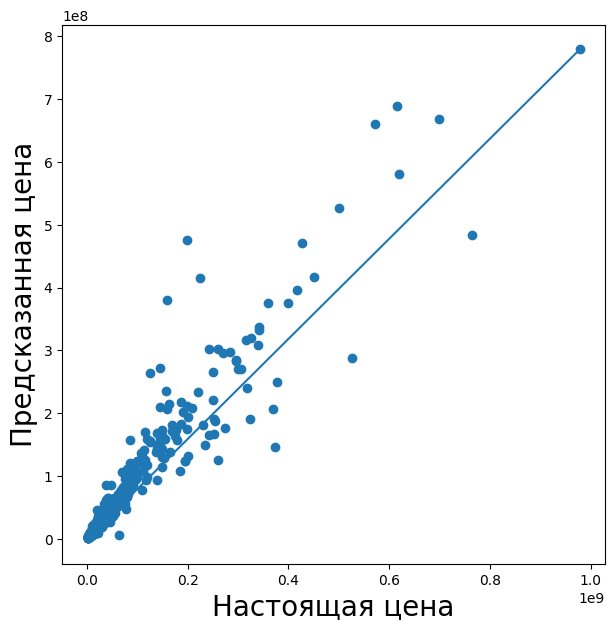

In [364]:
plt.figure(figsize=(7, 7))
plt.scatter(test_values, rf_predict) # рисуем точки, соответствущие парам настоящее значение - прогноз
plt.plot([0, max(test_values)], [0, max(rf_predict)]) # рисуем прямую, на которой предсказания и настоящие значения совпадают
plt.xlabel('Настоящая цена', fontsize=20)
plt.ylabel('Предсказанная цена', fontsize=20)

In [365]:
rf_predict_train = rf_model.predict(train_points)
print(mean_absolute_error(train_values, rf_predict_train))

2335127.435583707


Text(0, 0.5, 'Предсказанная цена')

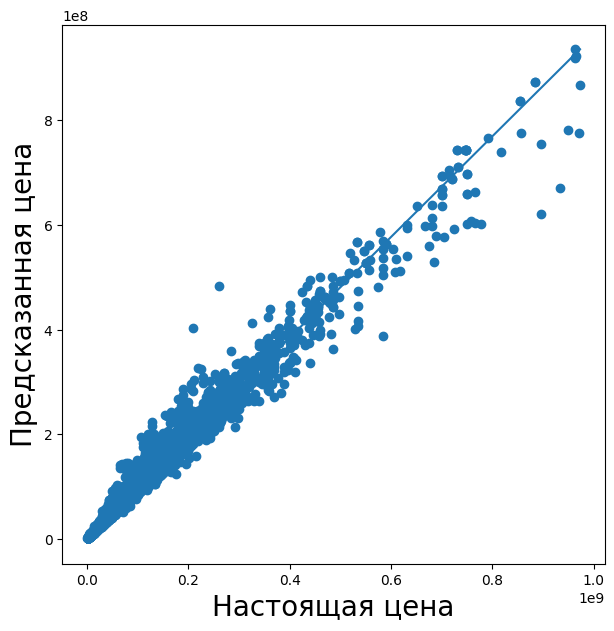

In [366]:
plt.figure(figsize=(7, 7))
plt.scatter(train_values, rf_predict_train) # рисуем точки, соответствущие парам настоящее значение - прогноз
plt.plot([0, max(train_values)], [0, max(rf_predict_train)]) # рисуем прямую, на которой предсказания и настоящие значения совпадают
plt.xlabel('Настоящая цена', fontsize=20)
plt.ylabel('Предсказанная цена', fontsize=20)